In [ ]:
# Pipeline YOLOv11m con dataset preprocesado.   

In [1]:
# =====================================================
# CONFIGURACIÓN INICIAL Y LIBRERÍAS
# =====================================================

# Módulos estándar de Python (Built-in)
import os
import json
import random
import subprocess
import platform
import psutil
import shutil

# Librerías para Computación Numérica y Manipulación de Datos
import numpy as np
import pandas as pd
import torch

# Librerías de Machine Learning / Visión por Computadora
from ultralytics import YOLO  # Para detección/segmentación de objetos
import cv2                    # OpenCV para visión artificial
import GPUtil                   # Para obtener el estado de la GPU
from PIL import Image            # (Python Imaging Library)

# Librerías para Visualización y Métricas
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, 'data')
OUTPUT_DIR = os.path.join(BASE_DIR, 'outputs')
YOLO_DATASET_DIR = os.path.join(BASE_DIR, 'dataset_yolo')

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(YOLO_DATASET_DIR, exist_ok=True)

In [2]:
# =====================================================
# CONFIGURACIÓN DE SEMILLA PARA REPRODUCIBILIDAD
# =====================================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print(f"Semilla global configurada en {SEED}")

Semilla global configurada en 42


In [3]:
# =====================================================
# CARACTERIZACIÓN DE HARDWARE Y ENTORNO
# =====================================================

print("CARACTERIZACIÓN DE HARDWARE Y ENTORNO\n" + "="*60)

# ==========================================
# Información general del sistema
# ==========================================
print("\n Sistema Operativo:")
print(f" - Nombre: {platform.system()}")
print(f" - Versión: {platform.version()}")
print(f" - Release: {platform.release()}")
print(f" - Arquitectura: {platform.architecture()[0]}")
print(f" - Procesador: {platform.processor()}")

# ==========================================
#  Información de CPU
# ==========================================
cpu_freq = psutil.cpu_freq()
print("\n CPU:")
print(f" - Núcleos físicos: {psutil.cpu_count(logical=False)}")
print(f" - Núcleos lógicos (threads): {psutil.cpu_count(logical=True)}")
print(f" - Frecuencia base: {cpu_freq.min:.2f} MHz")
print(f" - Frecuencia máxima: {cpu_freq.max:.2f} MHz")
print(f" - Frecuencia actual: {cpu_freq.current:.2f} MHz")
print(f" - Uso actual CPU: {psutil.cpu_percent(interval=1)}%")

# ==========================================
# Información de memoria RAM
# ==========================================
mem = psutil.virtual_memory()
print("\n Memoria RAM:")
print(f" - Total: {mem.total / (1024 ** 3):.2f} GB")
print(f" - Disponible: {mem.available / (1024 ** 3):.2f} GB")
print(f" - En uso: {mem.percent}%")

# ==========================================
# Información de GPU (usando GPUtil y PyTorch)
# ==========================================
if torch.cuda.is_available():
    print("\n GPU (CUDA disponible):")
    gpus = GPUtil.getGPUs()
    for gpu in gpus:
        print(f" - Nombre: {gpu.name}")
        print(f" - Memoria total: {gpu.memoryTotal:.0f} MB")
        print(f" - Memoria usada: {gpu.memoryUsed:.0f} MB")
        print(f" - Memoria libre: {gpu.memoryFree:.0f} MB")
        print(f" - Carga GPU: {gpu.load * 100:.1f}%")
        print(f" - Temperatura: {gpu.temperature}°C")
    print(f"\nCUDA disponible: {torch.cuda.is_available()}")
    print(f"Versión CUDA (PyTorch): {torch.version.cuda}")
    print(f"Dispositivo actual: {torch.cuda.get_device_name(0)}")
else:
    print("\n No se detectó GPU con soporte CUDA. Entrenamiento se ejecutará en CPU.")

# ==========================================
# Información de almacenamiento
# ==========================================
print("\n Almacenamiento:")
partitions = psutil.disk_partitions()
for p in partitions:
    try:
        usage = psutil.disk_usage(p.mountpoint)
        print(f" - {p.device} ({p.mountpoint}): {usage.total / (1024**3):.1f} GB total, {usage.free / (1024**3):.1f} GB libres")
    except PermissionError:
        continue

# ==========================================
# Versión de librerías clave
# ==========================================
print("\n Versiones de librerías clave:")
print(f" - Python: {platform.python_version()}")
print(f" - PyTorch: {torch.__version__}")
try:
    import ultralytics
    print(f" - Ultralytics: {ultralytics.__version__}")
except ImportError:
    print(" - Ultralytics: no instalado")

try:
    cudnn_version = torch.backends.cudnn.version()
    print(f" - cuDNN: {cudnn_version}")
except:
    print(" - cuDNN: no detectado")

print("\n Caracterización completada.\n")

CARACTERIZACIÓN DE HARDWARE Y ENTORNO

 Sistema Operativo:
 - Nombre: Windows
 - Versión: 10.0.26100
 - Release: 10
 - Arquitectura: 64bit
 - Procesador: Intel64 Family 6 Model 198 Stepping 2, GenuineIntel

 CPU:
 - Núcleos físicos: 24
 - Núcleos lógicos (threads): 24
 - Frecuencia base: 0.00 MHz
 - Frecuencia máxima: 2700.00 MHz
 - Frecuencia actual: 2700.00 MHz
 - Uso actual CPU: 6.8%

 Memoria RAM:
 - Total: 31.43 GB
 - Disponible: 18.28 GB
 - En uso: 41.8%

 GPU (CUDA disponible):
 - Nombre: NVIDIA GeForce RTX 5080 Laptop GPU
 - Memoria total: 16303 MB
 - Memoria usada: 0 MB
 - Memoria libre: 15915 MB
 - Carga GPU: 0.0%
 - Temperatura: 43.0°C

CUDA disponible: True
Versión CUDA (PyTorch): 12.8
Dispositivo actual: NVIDIA GeForce RTX 5080 Laptop GPU

 Almacenamiento:
 - C:\ (C:\): 951.6 GB total, 368.6 GB libres

 Versiones de librerías clave:
 - Python: 3.10.18
 - PyTorch: 2.8.0+cu128
 - Ultralytics: 8.3.216
 - cuDNN: 91002

 Caracterización completada.



In [4]:
# =====================================================
# DETECCIÓN DEL FORMATO DE ANOTACIONES
# =====================================================
COCO_DIR = os.path.join(DATASET_DIR, 'coco')
CSV_DIR = os.path.join(DATASET_DIR, 'csv')

if os.path.exists(COCO_DIR):
    DATA_FORMAT = 'COCO'
elif os.path.exists(CSV_DIR):
    DATA_FORMAT = 'CSV'
else:
    raise FileNotFoundError("No se encontró la carpeta 'coco' ni 'csv' dentro de 'data'.")

print(f"Formato detectado: {DATA_FORMAT}")

Formato detectado: COCO


In [5]:
# =====================================================
# RUTAS DE IMÁGENES Y ETIQUETAS
# =====================================================
IMAGES_DIR = os.path.join(DATASET_DIR, 'images')
TRAIN_IMAGES_DIR = os.path.join(IMAGES_DIR, 'train')
VAL_IMAGES_DIR = os.path.join(IMAGES_DIR, 'val')
TEST_IMAGES_DIR = os.path.join(IMAGES_DIR, 'test')

YOLO_LABELS_TRAIN = os.path.join(YOLO_DATASET_DIR, 'labels', 'train')
YOLO_LABELS_VAL = os.path.join(YOLO_DATASET_DIR, 'labels', 'val')
YOLO_LABELS_TEST = os.path.join(YOLO_DATASET_DIR, 'labels', 'test')

for d in [YOLO_LABELS_TRAIN, YOLO_LABELS_VAL, YOLO_LABELS_TEST]:
    os.makedirs(d, exist_ok=True)

In [6]:
# =====================================================
# VERIFICACIÓN DE CONTENIDO Y FUGAS DE DATOS
# =====================================================
def verificar_conjuntos(train_dir, val_dir, test_dir):
    train_imgs = set(os.listdir(train_dir))
    val_imgs = set(os.listdir(val_dir))
    test_imgs = set(os.listdir(test_dir))

    inter_train_val = train_imgs.intersection(val_imgs)
    inter_train_test = train_imgs.intersection(test_imgs)
    inter_val_test = val_imgs.intersection(test_imgs)

    print(f"Train: {len(train_imgs)} imágenes")
    print(f"Val: {len(val_imgs)} imágenes")
    print(f"Test: {len(test_imgs)} imágenes")

    if inter_train_val or inter_train_test or inter_val_test:
        print("ALERTA: Se detectaron posibles fugas de datos entre conjuntos.")
        if inter_train_val: print(f"  Coincidencias train/val: {len(inter_train_val)}")
        if inter_train_test: print(f"  Coincidencias train/test: {len(inter_train_test)}")
        if inter_val_test: print(f"  Coincidencias val/test: {len(inter_val_test)}")
    else:
        print("Verificación completada: sin fugas detectadas entre train, val y test.")

verificar_conjuntos(TRAIN_IMAGES_DIR, VAL_IMAGES_DIR, TEST_IMAGES_DIR)

Train: 4901 imágenes
Val: 111 imágenes
Test: 258 imágenes
Verificación completada: sin fugas detectadas entre train, val y test.


In [7]:
# =====================================================
# CONVERSIÓN DE ANOTACIONES A FORMATO YOLO
# =====================================================
def coco_to_yolo(coco_file, images_dir, output_labels_dir):
    with open(coco_file, 'r') as f:
        data = json.load(f)
    images = {img['id']: img for img in data['images']}
    for ann in data['annotations']:
        img_id = ann['image_id']
        if img_id not in images:
            continue
        img_info = images[img_id]
        img_name = img_info['file_name']
        img_path = os.path.join(images_dir, img_name)
        if not os.path.exists(img_path):
            continue
        img_w, img_h = img_info.get('width', 1), img_info.get('height', 1)
        bbox = ann['bbox']
        category_id = ann['category_id'] - 1
        x_center = (bbox[0] + bbox[2] / 2) / img_w
        y_center = (bbox[1] + bbox[3] / 2) / img_h
        width = bbox[2] / img_w
        height = bbox[3] / img_h
        label_path = os.path.join(output_labels_dir, os.path.splitext(img_name)[0] + '.txt')
        with open(label_path, 'a') as f:
            f.write(f"{category_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

def csv_to_yolo(csv_file, images_dir, output_labels_dir):
    df = pd.read_csv(csv_file)
    for _, row in df.iterrows():
        img_name = row['image']
        img_path = os.path.join(images_dir, img_name)
        if not os.path.exists(img_path):
            continue
        class_id = int(row['class_id'])
        x_center = ((row['xmin'] + row['xmax']) / 2) / row['width']
        y_center = ((row['ymin'] + row['ymax']) / 2) / row['height']
        width = (row['xmax'] - row['xmin']) / row['width']
        height = (row['ymax'] - row['ymin']) / row['height']
        label_path = os.path.join(output_labels_dir, os.path.splitext(img_name)[0] + '.txt')
        with open(label_path, 'a') as f:
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

if DATA_FORMAT == 'COCO':
    coco_to_yolo(os.path.join(COCO_DIR, 'train','train_annotations.json'), TRAIN_IMAGES_DIR, YOLO_LABELS_TRAIN)
    coco_to_yolo(os.path.join(COCO_DIR, 'val','val_annotations.json'), VAL_IMAGES_DIR, YOLO_LABELS_VAL)
    coco_to_yolo(os.path.join(COCO_DIR, 'test','test_annotations.json'), TEST_IMAGES_DIR, YOLO_LABELS_TEST)
elif DATA_FORMAT == 'CSV':
    csv_to_yolo(os.path.join(CSV_DIR, 'train','train_annotations.csv'), TRAIN_IMAGES_DIR, YOLO_LABELS_TRAIN)
    csv_to_yolo(os.path.join(CSV_DIR, 'val','val_annotations.csv'), VAL_IMAGES_DIR, YOLO_LABELS_VAL)
    csv_to_yolo(os.path.join(CSV_DIR, 'test','test_annotations.csv'), TEST_IMAGES_DIR, YOLO_LABELS_TEST)

In [8]:
# -----------------------------------------------------
# GENERAR EL ARCHIVO dataset.yaml
# -----------------------------------------------------

print("\nGenerando archivo dataset.yaml ...")

# Detectar número real de clases según el formato de anotaciones
if DATA_FORMAT == 'COCO':
    coco_train_file = os.path.join(COCO_DIR, 'train', 'train_annotations.json')
    with open(coco_train_file, 'r') as f:
        data = json.load(f)
    categories = [c['name'] for c in data.get('categories', [])]
    nc = len(categories)
    class_names = categories if categories else ['animal']
elif DATA_FORMAT == 'CSV':
    csv_train_file = os.path.join(CSV_DIR, 'train', 'train_annotations.csv')
    df = pd.read_csv(csv_train_file)
    if 'class_name' in df.columns:
        class_names = sorted(df['class_name'].unique().tolist())
    else:
        unique_ids = sorted(df['class_id'].unique().tolist())
        class_names = [f"class_{i}" for i in unique_ids]
    nc = len(class_names)
else:
    nc = 1
    class_names = ['animal']

yaml_content = f"""
# Ruta base del dataset
path: {YOLO_DATASET_DIR.replace(os.sep, '/')}

# Directorios relativos de imágenes
train: images/train
val: images/val
test: images/test

# Definición de clases
nc: {nc}
names: {class_names}
"""

yaml_path = os.path.join(YOLO_DATASET_DIR, 'dataset.yaml')
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"Archivo dataset.yaml generado correctamente con {nc} clases.")
print(f"Clases detectadas: {class_names}")
print(f"Ruta del YAML: {yaml_path}")


Generando archivo dataset.yaml ...
Archivo dataset.yaml generado correctamente con 6 clases.
Clases detectadas: ['Alcelaphinae', 'Buffalo', 'Kob', 'Warthog', 'Waterbuck', 'Elephant']
Ruta del YAML: C:\Users\durle\anaconda3\Fauna_Detection\dataset_yolo\dataset.yaml


In [9]:
# =====================================================
# VALIDACIÓN FINAL DE ESTRUCTURA YOLO 
# =====================================================

import shutil

print("\nVerificando estructura final del dataset YOLO...")

# Directorios esperados
YOLO_IMAGES_TRAIN = os.path.join(YOLO_DATASET_DIR, 'images', 'train')
YOLO_IMAGES_VAL = os.path.join(YOLO_DATASET_DIR, 'images', 'val')
YOLO_IMAGES_TEST = os.path.join(YOLO_DATASET_DIR, 'images', 'test')

for d in [YOLO_IMAGES_TRAIN, YOLO_IMAGES_VAL, YOLO_IMAGES_TEST]:
    os.makedirs(d, exist_ok=True)

# Función auxiliar para copiar si faltan archivos
def asegurar_imagenes(origen, destino):
    if not os.path.exists(origen):
        print(f"Advertencia: no existe el origen {origen}")
        return
    files = [f for f in os.listdir(origen) if os.path.isfile(os.path.join(origen, f))]
    if not files:
        print(f"Advertencia: no hay imágenes en {origen}")
        return
    if len(os.listdir(destino)) == 0:
        print(f"Copiando imágenes desde {origen} hacia {destino}...")
        for f in files:
            shutil.copy2(os.path.join(origen, f), os.path.join(destino, f))
    else:
        print(f"Directorio {destino} ya contiene imágenes ({len(os.listdir(destino))}).")

asegurar_imagenes(TRAIN_IMAGES_DIR, YOLO_IMAGES_TRAIN)
asegurar_imagenes(VAL_IMAGES_DIR, YOLO_IMAGES_VAL)
asegurar_imagenes(TEST_IMAGES_DIR, YOLO_IMAGES_TEST)

print("Estructura validada correctamente. Lista para el entrenamiento.\n")


Verificando estructura final del dataset YOLO...
Copiando imágenes desde C:\Users\durle\anaconda3\Fauna_Detection\data\images\train hacia C:\Users\durle\anaconda3\Fauna_Detection\dataset_yolo\images\train...
Copiando imágenes desde C:\Users\durle\anaconda3\Fauna_Detection\data\images\val hacia C:\Users\durle\anaconda3\Fauna_Detection\dataset_yolo\images\val...
Copiando imágenes desde C:\Users\durle\anaconda3\Fauna_Detection\data\images\test hacia C:\Users\durle\anaconda3\Fauna_Detection\dataset_yolo\images\test...
Estructura validada correctamente. Lista para el entrenamiento.



In [10]:
# -----------------------------------------------------
# (Opcional) Limpieza preventiva de etiquetas fuera de rango
# -----------------------------------------------------
def limpiar_etiquetas(labels_dir, nc):
    for file in os.listdir(labels_dir):
        if file.endswith('.txt'):
            file_path = os.path.join(labels_dir, file)
            with open(file_path, 'r') as f:
                lines = f.readlines()

            valid_lines = []
            for l in lines:
                parts = l.strip().split()
                if not parts:
                    continue
                try:
                    class_id = int(float(parts[0]))  # Maneja casos como '5.0'
                    if 0 <= class_id < nc:
                        # Reescribe la línea con class_id corregido (sin decimales)
                        valid_lines.append(f"{class_id} " + " ".join(parts[1:]) + "\n")
                except ValueError:
                    print(f"Advertencia: línea inválida en {file}: {l.strip()}")
                    continue

            if len(valid_lines) < len(lines):
                with open(file_path, 'w') as f:
                    f.writelines(valid_lines)
                print(f"Corregido: {file}")


 Se detectaron 9 imágenes marcadas como background.



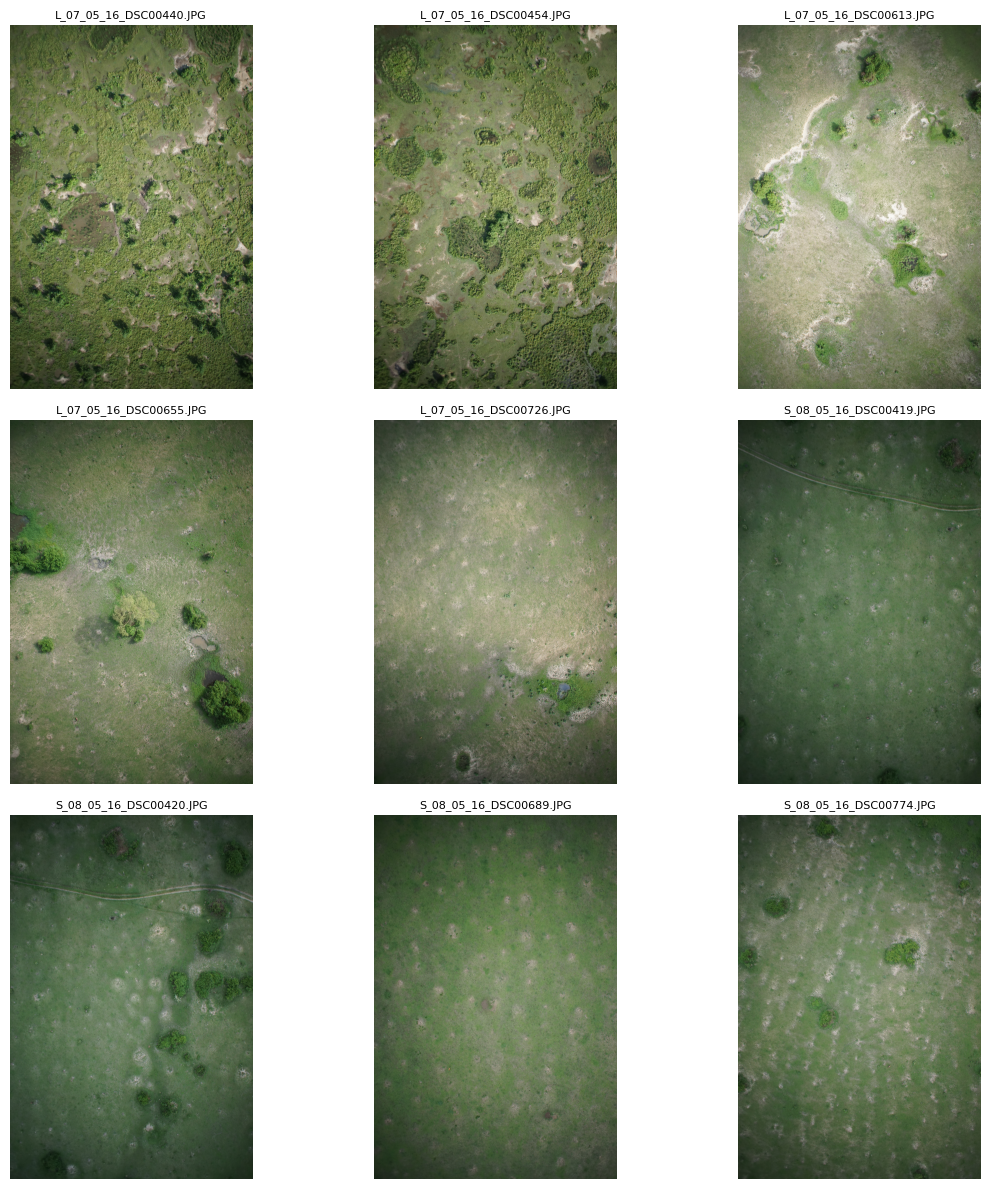

In [11]:
# =====================================================
# Detectando imágenes background
# =====================================================
%matplotlib inline

# Definir rutas
YOLO_DATASET_DIR = r"C:\Users\durle\anaconda3\Fauna_Detection\dataset_yolo"
YOLO_IMAGES_TRAIN = os.path.join(YOLO_DATASET_DIR, 'images', 'train')
YOLO_LABELS_TRAIN = os.path.join(YOLO_DATASET_DIR, 'labels', 'train')

# Detectar imágenes background
background_images = []
for img_file in os.listdir(YOLO_IMAGES_TRAIN):
    if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue
    img_name = os.path.splitext(img_file)[0]
    label_path = os.path.join(YOLO_LABELS_TRAIN, img_name + '.txt')
    if not os.path.exists(label_path) or os.path.getsize(label_path) == 0:
        background_images.append(img_file)

print(f"\n Se detectaron {len(background_images)} imágenes marcadas como background.\n")

# Mostrar imágenes
if len(background_images) == 0:
    print(" No hay imágenes sin anotaciones.")
else:
    cols = 3
    rows = (len(background_images) + cols - 1) // cols
    plt.figure(figsize=(cols * 4, rows * 4))
    for i, img_file in enumerate(background_images):
        img_path = os.path.join(YOLO_IMAGES_TRAIN, img_file)
        if os.path.exists(img_path):
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.title(img_file, fontsize=8)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

In [14]:
# =====================================================
# ENTRENAMIENTO CON YOLOv11m (CHECKPOINTS, REANUDACIÓN, STOPPING)
# =====================================================

# 1️. DETECTAR DISPOSITIVO (GPU o CPU)

if torch.cuda.is_available():
    device = 0  # usa GPU CUDA 0
    print(f" GPU detectada: {torch.cuda.get_device_name(0)}")
else:
    device = 'cpu'
    print(" No se detectó GPU. El entrenamiento se ejecutará en CPU.")

# 2. DEFINIR RUTAS Y CHECKPOINT

CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, 'yolov11m_training')
LAST_CHECKPOINT = os.path.join(CHECKPOINT_DIR, 'weights', 'last.pt')

# 3. CARGAR MODELO

if os.path.exists(LAST_CHECKPOINT):
    print("Checkpoint detectado. Reanudando entrenamiento desde el último punto guardado.")
    model = YOLO(LAST_CHECKPOINT)
else:
    print("No se encontró checkpoint previo. Entrenamiento desde cero (fine-tuning desde los pesos base).")
    model = YOLO('yolo11m.pt')

# 4️. CONFIGURAR Y EJECUTAR ENTRENAMIENTO

results = model.train(
    data=yaml_path,
    epochs=100,
    imgsz=640,  # redimensiona a 640×640 píxeles - balance entre precisión y velocidad
    batch=16,
    lr0=1e-3,
    lrf=0.01,

    optimizer='SGD',  # Estable en entrenamientos largos, menos VRAM y mejor generalización (recomendado por Ultralytics)

    momentum=0.937,
    weight_decay=5e-4, # L2 - prevenir sobreajuste (overfitting).
    warmup_epochs=3, # previene inestabilidad inicial.
    close_mosaic=15, # desactiva mosaic en últimas 15 épocas  - refinar las detecciones
    patience=10,     # aumentar paciencia para evitar early stop prematuro (5 before)

    device=device,
    project=OUTPUT_DIR,
    name='yolov11m_training',
    save=True,
    resume=os.path.exists(LAST_CHECKPOINT),  # reanuda si existe checkpoint
    cache=True,    # acelerar entrenamientos posteriores.  
    workers=6,     # aumentar workers si IO lo permite (4 before)

    pretrained=True,  # usa pesos base
    save_period=1,   # guardar checkpoints por época (útil para seleccionar mejor checkpoint)
        
    # Utilidades que ayudan en validación / despliegue
    deterministic=True,        # reproducibilidad
    seed=SEED
)

 GPU detectada: NVIDIA GeForce RTX 5080 Laptop GPU
No se encontró checkpoint previo. Entrenamiento desde cero (fine-tuning desde los pesos base).
New https://pypi.org/project/ultralytics/8.3.221 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.216  Python-3.10.18 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5080 Laptop GPU, 16303MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=15, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\durle\anaconda3\Fauna_Detection\dataset_yolo\dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False

2025/10/26 21:11:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


MLflow: logging run_id(7555556249d94d71a5676c99cc51d1b0) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 6 dataloader workers
Logging results to C:\Users\durle\anaconda3\Fauna_Detection\outputs\yolov11m_training
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      1/100       8.1G      2.315      4.726      1.083         26        640: 100% ━━━━━━━━━━━━ 307/307 2.6it/s 1:60<0.5ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.1it/s 3.5s0.6ss
                   all        111        978     0.0944      0.101     0.0571     0.0165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      2/100      8.05G      1.997      2.211     0.9543         22        640: 100% ━━━━━━━━━━━━ 307/307 2

In [15]:
# =====================================================
# EVALUACIÓN DEL MODELO EN VALIDACIÓN Y TEST
# =====================================================

BEST_MODEL = os.path.join(CHECKPOINT_DIR, 'weights', 'best.pt')
LAST_MODEL = os.path.join(CHECKPOINT_DIR, 'weights', 'last.pt')

# Se selecciona el mejor modelo disponible
if os.path.exists(BEST_MODEL):
    print("Evaluando modelo: best.pt")
    model = YOLO(BEST_MODEL)
elif os.path.exists(LAST_MODEL):
    print("Evaluando modelo: last.pt (no se encontró best.pt)")
    model = YOLO(LAST_MODEL)
else:
    raise FileNotFoundError("No se encontró ningún modelo entrenado para evaluación (best.pt o last.pt).")

Evaluando modelo: best.pt


In [16]:
# -----------------------------------------------------
# 1. Evaluación sobre VALIDACIÓN
# -----------------------------------------------------
print("\n=== EVALUACIÓN SOBRE CONJUNTO DE VALIDACIÓN ===")
val_metrics = model.val(data=yaml_path, split='val')
print("Resultados del conjunto VALIDACIÓN:")
print(val_metrics)

val_results_file = os.path.join(CHECKPOINT_DIR, 'val_results.txt')
with open(val_results_file, 'w') as f:
    f.write(str(val_metrics))
print(f"Resultados de validación guardados en: {val_results_file}")


=== EVALUACIÓN SOBRE CONJUNTO DE VALIDACIÓN ===
Ultralytics 8.3.216  Python-3.10.18 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5080 Laptop GPU, 16303MiB)
YOLO11m summary (fused): 125 layers, 20,034,658 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access  (ping: 0.30.0 ms, read: 1510.7163.2 MB/s, size: 10491.9 KB)
val: Scanning C:\Users\durle\anaconda3\Fauna_Detection\dataset_yolo\labels\val.cache... 111 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 111/111  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.3it/s 5.6s0.2s
                   all        111        978      0.555      0.271      0.314      0.105
          Alcelaphinae         29        369      0.486      0.434      0.376      0.105
               Buffalo         11        102      0.434      0.598      0.515      0.146
                   Kob         22        161      0.805      0.385      0.521      0.167
               Warthog         

In [17]:
# -----------------------------------------------------
# 2. Evaluación sobre TEST
# -----------------------------------------------------
print("\n=== EVALUACIÓN FINAL SOBRE CONJUNTO TEST ===")
test_metrics = model.val(data=yaml_path, split='test')
print("Resultados del conjunto TEST:")
print(test_metrics)

test_results_file = os.path.join(CHECKPOINT_DIR, 'test_results.txt')
with open(test_results_file, 'w') as f:
    f.write(str(test_metrics))
print(f"Resultados del test guardados en: {test_results_file}")


=== EVALUACIÓN FINAL SOBRE CONJUNTO TEST ===
Ultralytics 8.3.216  Python-3.10.18 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5080 Laptop GPU, 16303MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 1529.3211.6 MB/s, size: 6934.4 KB)
val: Scanning C:\Users\durle\anaconda3\Fauna_Detection\dataset_yolo\labels\test... 258 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 258/258 1.6Kit/s 0.2s<0.2s
val: New cache created: C:\Users\durle\anaconda3\Fauna_Detection\dataset_yolo\labels\test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.0it/s 5.7s0.1s
                   all        258       2299     0.0706     0.0237     0.0231    0.00747
          Alcelaphinae         44        675          0          0          0          0
               Buffalo         22        349          0          0          0          0
                   Kob         88        477          0          0          0          0
              


=== Test ===
| Split   | Class        |   Images |   Instances |   Precision |   Recall |   mAP50 |   mAP50-95 |
|---------|--------------|----------|-------------|-------------|----------|---------|------------|
| Test    | Alcelaphinae |       44 |         675 |       0     |    0     |   0     |      0     |
| Test    | Buffalo      |       22 |         349 |       0     |    0     |   0     |      0     |
| Test    | Elephant     |      100 |         688 |       0.424 |    0.142 |   0.139 |      0.045 |
| Test    | Kob          |       88 |         477 |       0     |    0     |   0     |      0     |
| Test    | Warthog      |       23 |          74 |       0     |    0     |   0     |      0     |
| Test    | Waterbuck    |        4 |          36 |       0     |    0     |   0     |      0     |
| Test    | all          |      258 |        2299 |       0.071 |    0.024 |   0.023 |      0.007 |

=== Train ===
| Split   | Class        |   Images |   Instances |   Precision |   Rec

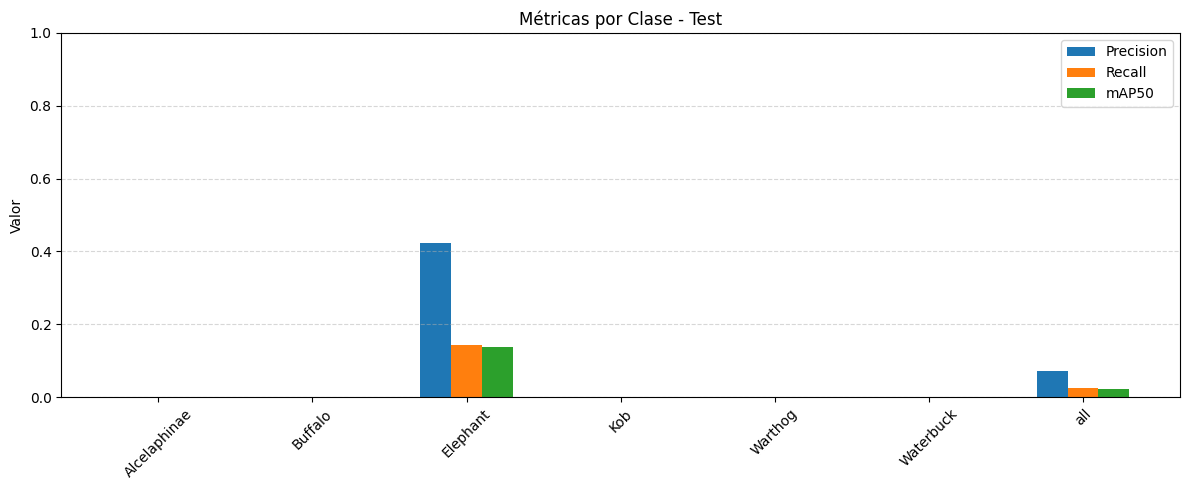

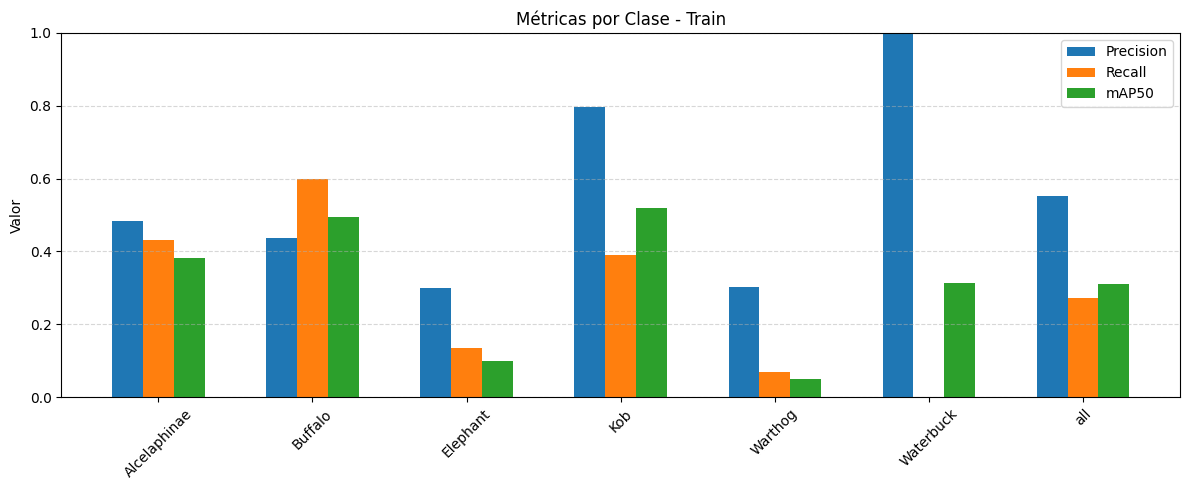

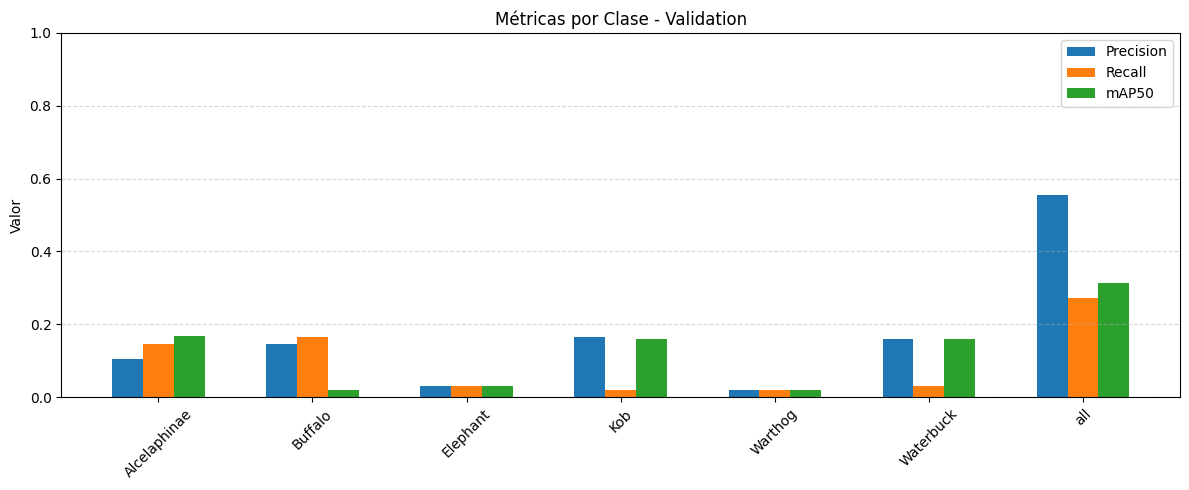

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

# Datos de la tabla
data = [
    ["Train", "all", 111, 978, 0.553, 0.271, 0.310, 0.104],
    ["Train", "Alcelaphinae", 29, 369, 0.484, 0.431, 0.381, 0.103],
    ["Train", "Buffalo", 11, 102, 0.437, 0.598, 0.495, 0.150],
    ["Train", "Kob", 22, 161, 0.796, 0.391, 0.518, 0.159],
    ["Train", "Warthog", 14, 43, 0.303, 0.070, 0.051, 0.020],
    ["Train", "Waterbuck", 7, 39, 1.000, 0.000, 0.314, 0.162],
    ["Train", "Elephant", 35, 264, 0.300, 0.136, 0.098, 0.031],
    ["Validation", "all", 111, 978, 0.555, 0.271, 0.314, 0.105],
    ["Validation", "Alcelaphinae", 29, 369, 0.105, 0.146, 0.167, 0.019],
    ["Validation", "Buffalo", 11, 102, 0.146, 0.166, 0.019, 0.019],
    ["Validation", "Kob", 22, 161, 0.166, 0.019, 0.160, 0.032],
    ["Validation", "Warthog", 14, 43, 0.019, 0.019, 0.019, 0.019],
    ["Validation", "Waterbuck", 7, 39, 0.161, 0.032, 0.161, 0.032],
    ["Validation", "Elephant", 35, 264, 0.032, 0.032, 0.032, 0.032],
    ["Test", "all", 258, 2299, 0.071, 0.024, 0.023, 0.007],
    ["Test", "Alcelaphinae", 44, 675, 0.000, 0.000, 0.000, 0.000],
    ["Test", "Buffalo", 22, 349, 0.000, 0.000, 0.000, 0.000],
    ["Test", "Kob", 88, 477, 0.000, 0.000, 0.000, 0.000],
    ["Test", "Warthog", 23, 74, 0.000, 0.000, 0.000, 0.000],
    ["Test", "Waterbuck", 4, 36, 0.000, 0.000, 0.000, 0.000],
    ["Test", "Elephant", 100, 688, 0.424, 0.142, 0.139, 0.045]
]

columns = ["Split", "Class", "Images", "Instances", "Precision", "Recall", "mAP50", "mAP50-95"]

# Crear DataFrame y formatear métricas
df = pd.DataFrame(data, columns=columns)
df[['Precision','Recall','mAP50','mAP50-95']] = df[['Precision','Recall','mAP50','mAP50-95']].round(3)
df = df.sort_values(by=["Split", "Class"])

# Mostrar tabla separada por Split
for split in df['Split'].unique():
    print(f"\n=== {split} ===")
    subset = df[df['Split'] == split]
    print(tabulate(subset, headers='keys', tablefmt='github', showindex=False))


# Línea divisoria entre tablas y gráficas
print("\n" + "="*150 + "\n")

# ============================================
# Visualización gráfica mejorada (barras)
# ============================================
splits = df['Split'].unique()
metrics = ['Precision', 'Recall', 'mAP50']
colors = ['#1f77b4','#ff7f0e','#2ca02c']  # colores distintos para cada métrica

for split in splits:
    subset = df[df['Split'] == split]
    x = range(len(subset))
    width = 0.2  # ancho de las barras

    plt.figure(figsize=(12,5))
    for i, metric in enumerate(metrics):
        plt.bar([p + i*width for p in x], subset[metric], width=width, label=metric, color=colors[i])

    plt.xticks([p + width for p in x], subset['Class'], rotation=45)
    plt.ylim(0, 1)
    plt.ylabel("Valor")
    plt.title(f"Métricas por Clase - {split}")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [47]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ============================================
# Datos del modelo según la tabla previa
# Multiplicar por 100 para estar en la misma escala que HerdNet
# ============================================

# Validation
precision_val = np.array([0.555, 0.105, 0.146, 0.166, 0.019, 0.161, 0.032])*100
recall_val    = np.array([0.271, 0.146, 0.166, 0.019, 0.019, 0.032, 0.032])*100
mAP50_val     = np.array([0.314, 0.167, 0.019, 0.160, 0.019, 0.161, 0.032])*100

# Test
precision_test = np.array([0.071, 0.000, 0.000, 0.000, 0.000, 0.000, 0.424])*100
recall_test    = np.array([0.024, 0.000, 0.000, 0.000, 0.000, 0.000, 0.142])*100
mAP50_test     = np.array([0.023, 0.000, 0.000, 0.000, 0.000, 0.000, 0.139])*100

# Valores ideales (100%) para MAE/RMSE
y_true = np.array([100]*7)

# ============================================
# Función para calcular MAE, RMSE y F1 promedio
# ============================================
def calcular_metricas(y_true, precision, recall, mAP50, split_name):
    mae = mean_absolute_error(y_true, mAP50)
    rmse = np.sqrt(mean_squared_error(y_true, mAP50))
    
    # F1-score por clase
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # evitar división por cero
    f1_avg = np.mean(f1_scores)
    
    print(f"\n=== {split_name} ===")
    print(f"MAE  = {mae:.3f}")
    print(f"RMSE = {rmse:.3f}")
    print(f"F1 promedio = {f1_avg:.2f}%")
    
# ============================================
# Cálculo por split
# ============================================
calcular_metricas(y_true, precision_val, recall_val, mAP50_val, "Validation")
calcular_metricas(y_true, precision_test, recall_test, mAP50_test, "Test")

print("\n" + "="*18 + "\n")

print("Métricas HerdNet:")
print(f"herdnet_mae = 1.9")
print(f"herdnet_rmse = 3.6") 
print(f"herdnet_f1 = 83.5")

print("\n" + " "*5 + "\n")


=== Validation ===
MAE  = 87.543
RMSE = 88.121
F1 promedio = 11.15%

=== Test ===
MAE  = 97.686
RMSE = 97.803
F1 promedio = 3.55%


Métricas HerdNet:
herdnet_mae = 1.9
herdnet_rmse = 3.6
herdnet_f1 = 83.5

     

